In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab \Notebooks/microscopy_self_supervised_learning/

/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [5]:
metadata_with_moa = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/processed/metadata_with_moa.csv")
metadata_with_moa.head(3)

,Unnamed: 0,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,plate,well,Replicate,compound,concentration,moa
0,0,1,11,Week1_150607_B04_s3_w135D66B4C-0548-4AB8-A57B-...,Week1/Week1_22123,Week1_150607_B04_s3_w2D81AEFB9-9DD4-4B59-9177-...,Week1/Week1_22123,Week1_150607_B04_s3_w408BE006A-BF34-457E-81A9-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors
1,1,1,12,Week1_150607_B04_s4_w1EB720AD1-83BA-48A7-8C47-...,Week1/Week1_22123,Week1_150607_B04_s4_w261B79A05-7534-46F3-8C80-...,Week1/Week1_22123,Week1_150607_B04_s4_w49FF7E7B1-F049-4994-BCA2-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors
2,2,1,9,Week1_150607_B04_s1_w11323931B-BDA7-4F42-870E-...,Week1/Week1_22123,Week1_150607_B04_s1_w2F8F7EA7A-EC57-49CA-A556-...,Week1/Week1_22123,Week1_150607_B04_s1_w494DCA5C4-3531-497D-A8B0-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors


Step 1: Load & stack channels

In [6]:
import os
import numpy as np
import tifffile as tiff

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/raw"

def fix_path(pathname):
    return pathname.split("/")[-1]

def load_triplet_from_metadata(row):
    dapi_path = os.path.join(BASE_DIR, fix_path(row["Image_PathName_DAPI"]), row["Image_FileName_DAPI"]),

    tubulin_path = os.path.join(BASE_DIR, fix_path(row["Image_PathName_Tubulin"]), row["Image_FileName_Tubulin"])

    actin_path = os.path.join(BASE_DIR, fix_path(row["Image_PathName_Actin"]), row["Image_FileName_Actin"])

    dapi = tiff.imread(dapi_path)
    tubulin = tiff.imread(tubulin_path)
    actin = tiff.imread(actin_path)

    return np.stack([dapi, tubulin, actin], axis=0)  # (3, H, W)

In [7]:
row = metadata_with_moa.iloc[0]
img = load_triplet_from_metadata(row)

print(img.shape)  # should be (3, 1024, 1280)

(3, 1024, 1280)


Intensity normalization (per channel)

In [8]:
#because microscope brightness varies per stain.
def normalize(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

In [9]:
img_norm = np.stack([normalize(c) for c in img])
img_norm

array([[[0.03736264, 0.03296703, 0.03736264, ..., 0.04395605,
         0.04175824, 0.03736264],
        [0.03516484, 0.03736264, 0.04395605, ..., 0.04395605,
         0.03956044, 0.03956044],
        [0.04835165, 0.04615385, 0.04175824, ..., 0.04175824,
         0.03956044, 0.04175824],
        ...,
        [0.04175824, 0.04175824, 0.04175824, ..., 0.04395605,
         0.04175824, 0.03736264],
        [0.04395605, 0.03956044, 0.04395605, ..., 0.03956044,
         0.04835165, 0.03516484],
        [0.03736264, 0.03956044, 0.03736264, ..., 0.03516484,
         0.03076923, 0.03076923]],

       [[0.00641212, 0.00641212, 0.0058292 , ..., 0.00262314,
         0.00408044, 0.00553774],
        [0.00495482, 0.0058292 , 0.00495482, ..., 0.00524628,
         0.00612066, 0.00349752],
        [0.0058292 , 0.00524628, 0.00524628, ..., 0.00320606,
         0.0043719 , 0.00349752],
        ...,
        [0.0029146 , 0.0043719 , 0.00466336, ..., 0.00699505,
         0.00699505, 0.00699505],
        [0.0

Resize images (for CNNs)

In [10]:
# Too big (1024, 1280)
import cv2

def resize_img(img, size=(224,224)):
    return np.stack([cv2.resize(c, size) for c in img])

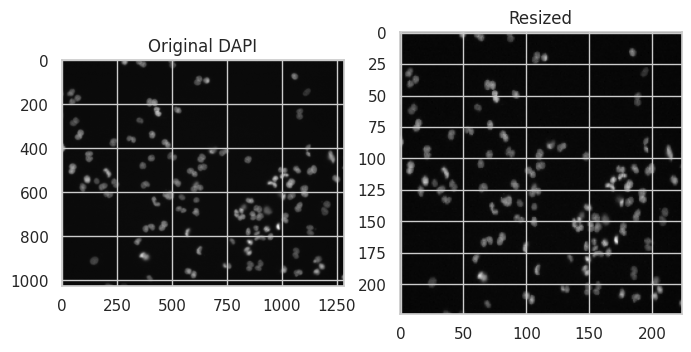

In [11]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(img[0], cmap='gray'); ax[0].set_title("Original DAPI")
ax[1].imshow(resize_img(img_norm)[0], cmap='gray'); ax[1].set_title("Resized+normalized")
plt.show()

Build dataset array (small subset first)

In [12]:
processed_images = []
labels = []

for i, row in metadata_with_moa.head(100).iterrows():
    img = load_triplet_from_metadata(row)
    img = np.stack([normalize(c) for c in img])
    img = resize_img(img)
    processed_images.append(img)
    labels.append(row['moa'])

processed_images = np.array(processed_images)

In [13]:
np.save("data/processed/images.npy", processed_images)
metadata_with_moa.head(100).to_csv("data/processed/labels.csv", index=False)

PyTorch Dataset class

In [15]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2)
train_idx, test_idx = next(gss.split(metadata_with_moa, groups=metadata_with_moa['compound']))

Save splits:

In [22]:
np.save("data/splits/train_idx.npy", train_idx)
np.save("data/splits/test_idx.npy", test_idx)

In [23]:
import torch
from torch.utils.data import Dataset

class MicroscopyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx], dtype=torch.float32)
        y = self.labels[idx]
        return x, y

“We preprocess microscopy images by loading three fluorescent channels, applying per-channel normalization, resizing to CNN-compatible resolution, and storing them as 3-channel tensors suitable for self-supervised representation learning.”


# Sanity Check

In [24]:
import numpy as np
import pandas as pd

train_idx = np.load("data/splits/train_idx.npy")
test_idx  = np.load("data/splits/test_idx.npy")

train_meta = metadata_with_moa.iloc[train_idx].reset_index(drop=True)
test_meta  = metadata_with_moa.iloc[test_idx].reset_index(drop=True)

print(train_meta.shape, test_meta.shape)

(276, 15) (24, 15)


In [25]:
len(train_meta) + len(test_meta) == len(metadata_with_moa)

True

In [29]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/raw"

def load_3channel_image(row):
    paths = [
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_DAPI"]), row["Image_FileName_DAPI"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Tubulin"]), row["Image_FileName_Tubulin"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Actin"]), row["Image_FileName_Actin"]),
    ]

    channels = [tiff.imread(p) for p in paths]   # list of (H,W)
    img = np.stack(channels, axis=0)             # (3,H,W)
    return img

In [30]:
import torch
from torch.utils.data import Dataset

class MicroscopyDataset(Dataset):
    def __init__(self, metadata_df):
        self.meta = metadata_df

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img = load_3channel_image(row)   # (3,H,W)
        label = row["moa"]               # or encode later

        x = torch.tensor(img, dtype=torch.float32)
        return x, label

In [31]:
train_dataset = MicroscopyDataset(train_meta)

x, y = train_dataset[0]

print("Image shape:", x.shape)   # should be (3, H, W)
print("Label:", y)

Image shape: torch.Size([3, 1024, 1280])
Label: Actin disruptors
